# CATBOOST CLASSIFIER ------------------------------------------------------------------------------------

### Get Train, Valid, Test data

In [11]:
import pandas as pd
from my_libs import lib_tools as pt

# run_type = 'dev'
run_type = 'prd'
gen_sample = True
find_best_params = True

X_train, y_train, X_valid, y_valid, X_test, y_test = pt.get_train_valid_test_data(run_type)
print("Train, valid and Test data loaded")

Train, valid and Test data loaded


### Resample data with SMOTEN()

In [12]:
if gen_sample:
    X_train, y_train = pt.get_data_resampled(X=X_train, y=y_train, verbose=1)
    # Save data generated
    X_train.to_pickle(f'./pickles/X_train_smote_{run_type}.pkl')
    y_train.to_pickle(f'./pickles/y_train_smote_{run_type}.pkl')
else:
    # Load data previously generated
    X_train = pd.read_pickle(f'./pickles/X_train_smote_{run_type}.pkl')
    y_train = pd.read_pickle(f'./pickles/y_train_smote_{run_type}.pkl')

C:\Users\nicol\AppData\Roaming\Python\Python39\site-packages\imblearn\over_sampling\_smote\base.py:858: FutureWarning:

The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.



--- Smote applied in 6633.26180768013 seconds ---
Classes cardinality after resampling :
1    146822
0    146822
Name: grav, dtype: int64
X shape : (192000, 27) -> (293644, 27)
y shape : (192000,) -> (293644,)


### Find best hyperparameters for model with Optuna

In [13]:
import time
import optuna
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

if find_best_params:

    start_time = time.time()

    def objective(trial):

        dt_iterations    = trial.suggest_int('iterations', 50, 300)
        dt_learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)

        classifier_obj = CatBoostClassifier(iterations=dt_iterations, learning_rate=dt_learning_rate, cat_features=list(X_train.columns), verbose=0)
        score = cross_val_score(classifier_obj, X_train, y_train, cv=3, scoring="roc_auc", verbose=1)
        accuracy = score.mean()

        return accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=5)

    print("--- CatBoost Classifier - Optimization with Optuna performed in %s seconds ---" % (time.time() - start_time))
    print(f"Best params : {study.best_params}")

[I 2023-02-26 13:02:00,473] A new study created in memory with name: no-name-7ef45787-654b-4426-bd1f-c13614d236be
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.0min finished
[I 2023-02-26 13:09:02,494] Trial 0 finished with value: 0.8493138420732841 and parameters: {'iterations': 252, 'learning_rate': 0.08191096214612462}. Best is trial 0 with value: 0.8493138420732841.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished
[I 2023-02-26 13:10:25,284] Trial 1 finished with value: 0.7908950584164893 and parameters: {'iterations': 137, 'learning_rate': 0.008916052847424184}. Best is trial 0 with value: 0.8493138420732841.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.1min finished
[I 2023-02-26 13:16:29,320] Trial 

--- CatBoost Classifier - Optimization with Optuna performed in 1274.0922906398773 seconds ---
Best params : {'iterations': 252, 'learning_rate': 0.08191096214612462}


In [14]:
if find_best_params:
    from optuna.visualization import plot_optimization_history
    plot_optimization_history(study)

### Confusion Matrix

In [15]:
from my_libs.model_evaluator import ModelEvaluator

if find_best_params:

    params = study.best_params
    params['cat_features'] = list(X_train.columns)

    evaluator = ModelEvaluator(model_type='CatBoostClassifier', params=params, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    model = evaluator.evaluate()

0:	learn: 0.6664443	total: 604ms	remaining: 2m 31s
1:	learn: 0.6445972	total: 1.26s	remaining: 2m 37s
2:	learn: 0.6272911	total: 1.84s	remaining: 2m 32s
3:	learn: 0.6112756	total: 2.52s	remaining: 2m 36s
4:	learn: 0.5992772	total: 3.17s	remaining: 2m 36s
5:	learn: 0.5883499	total: 3.79s	remaining: 2m 35s
6:	learn: 0.5786891	total: 4.53s	remaining: 2m 38s
7:	learn: 0.5697922	total: 5.27s	remaining: 2m 40s
8:	learn: 0.5626646	total: 5.96s	remaining: 2m 41s
9:	learn: 0.5544320	total: 6.79s	remaining: 2m 44s
10:	learn: 0.5486861	total: 7.43s	remaining: 2m 42s
11:	learn: 0.5431454	total: 8.06s	remaining: 2m 41s
12:	learn: 0.5382626	total: 8.65s	remaining: 2m 39s
13:	learn: 0.5313384	total: 9.39s	remaining: 2m 39s
14:	learn: 0.5258695	total: 10s	remaining: 2m 38s
15:	learn: 0.5218088	total: 10.7s	remaining: 2m 37s
16:	learn: 0.5174426	total: 11.3s	remaining: 2m 36s
17:	learn: 0.5132585	total: 11.9s	remaining: 2m 35s
18:	learn: 0.5101652	total: 12.7s	remaining: 2m 35s
19:	learn: 0.5074098	tot

Classe prédite,0,1
Classe réelle,,
0,44728,3962
1,6713,4596



Classification report :
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     48690
           1       0.54      0.41      0.46     11309

    accuracy                           0.82     59999
   macro avg       0.70      0.66      0.68     59999
weighted avg       0.81      0.82      0.81     59999



### Fit best model - Plot Train and Test learning curves

0:	learn: 0.6664443	total: 724ms	remaining: 3m 1s
1:	learn: 0.6445972	total: 1.56s	remaining: 3m 14s
2:	learn: 0.6272911	total: 2.42s	remaining: 3m 21s
3:	learn: 0.6112756	total: 3.4s	remaining: 3m 30s
4:	learn: 0.5992772	total: 4.38s	remaining: 3m 36s
5:	learn: 0.5883499	total: 5.3s	remaining: 3m 37s
6:	learn: 0.5786891	total: 6.14s	remaining: 3m 35s
7:	learn: 0.5697922	total: 6.92s	remaining: 3m 31s
8:	learn: 0.5626646	total: 7.65s	remaining: 3m 26s
9:	learn: 0.5544320	total: 8.54s	remaining: 3m 26s
10:	learn: 0.5486861	total: 9.27s	remaining: 3m 23s
11:	learn: 0.5431454	total: 10s	remaining: 3m 20s
12:	learn: 0.5382626	total: 10.8s	remaining: 3m 19s
13:	learn: 0.5313384	total: 11.8s	remaining: 3m 21s
14:	learn: 0.5258695	total: 12.8s	remaining: 3m 21s
15:	learn: 0.5218088	total: 13.7s	remaining: 3m 22s
16:	learn: 0.5174426	total: 14.6s	remaining: 3m 21s
17:	learn: 0.5132585	total: 15.3s	remaining: 3m 19s
18:	learn: 0.5101652	total: 16.1s	remaining: 3m 17s
19:	learn: 0.5074098	total:

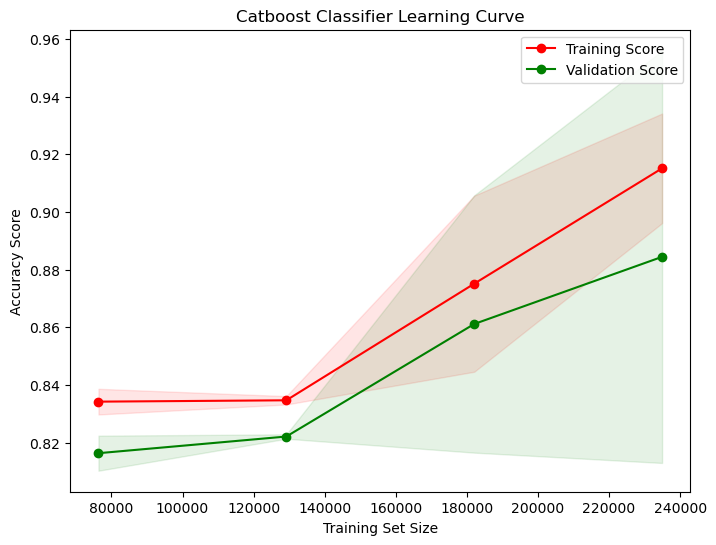

In [16]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
%matplotlib inline

# Train the best model
params = study.best_params
params['cat_features'] = list(X_train.columns)
model = CatBoostClassifier(**params)
model.fit(X_train, y_train)

# Compute the learning curve
train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std  = np.std(valid_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.title('Catboost Classifier Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation Score')
plt.legend(loc='best')
plt.show()

### Plot ROC curves (from estimator & from predictions)

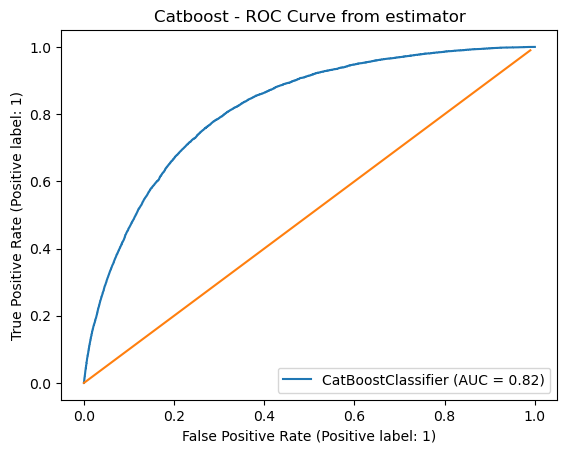

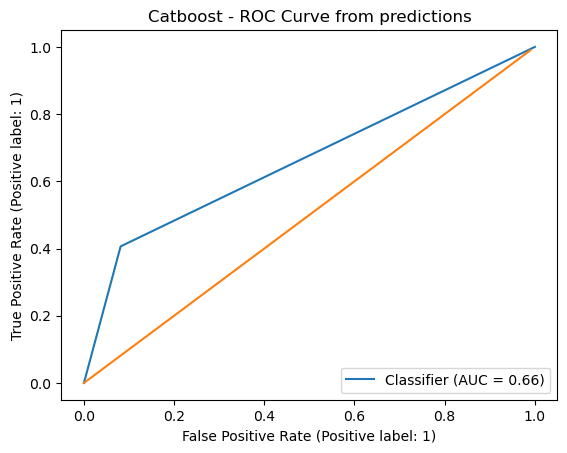

In [17]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.title('Catboost - ROC Curve from estimator')

RocCurveDisplay.from_predictions(y_test, model.predict(X_test))
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.title('Catboost - ROC Curve from predictions');

### Change proba threshold to improve f1-score

In [26]:
import numpy as np
from sklearn.metrics import classification_report, plot_roc_curve, f1_score, precision_score, recall_score
# plot_roc_curve(model, X_train, y_train)

thresholds = np.arange(0.20, 0.80, 0.01)
scores_f1 = []
scores_prec = []
scores_recall = []
for k in thresholds:
    y_pred = (model.predict_proba(X_test)[:,1] >= k).astype(bool)
    scores_f1.append(f1_score(y_test, y_pred))
    scores_prec.append(precision_score(y_test, y_pred))
    scores_recall.append(recall_score(y_test, y_pred))

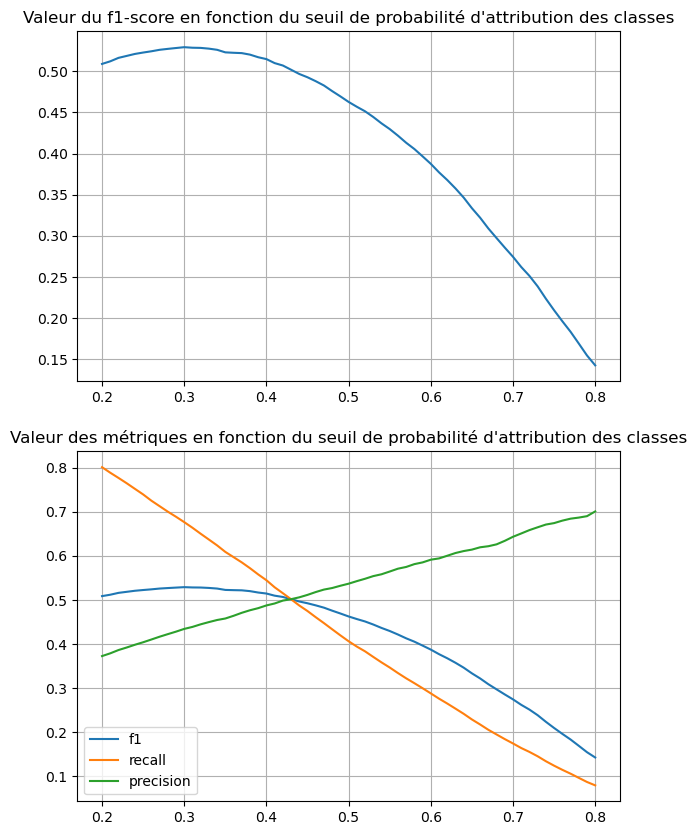

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(2,1, figsize=(7,10))
plt.grid()
axs[0].plot(thresholds, scores_f1, label='f1')
axs[0].set_title("Valeur du f1-score en fonction du seuil de probabilité d'attribution des classes")
axs[0].grid()
axs[1].plot(thresholds, scores_f1, label='f1')
axs[1].plot(thresholds, scores_recall, label='recall')
axs[1].plot(thresholds, scores_prec, label='precision')
axs[1].set_title("Valeur des métriques en fonction du seuil de probabilité d'attribution des classes")
axs[1].grid()
plt.grid()
plt.legend();

In [28]:
from sklearn.metrics import classification_report
y_pred = (model.predict_proba(X_test)[:,1] >= 0.42).astype(bool)

display(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))

print("\nClassification report :")
print(classification_report(y_test, y_pred))

Classe prédite,False,True
Classe réelle,,
0,42830,5860
1,5480,5829



Classification report :
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     48690
           1       0.50      0.52      0.51     11309

    accuracy                           0.81     59999
   macro avg       0.69      0.70      0.70     59999
weighted avg       0.81      0.81      0.81     59999



### Save model to h5

In [19]:
from joblib import dump
# Save the model to an h5 file using joblib
dump(model, f'h5_models/model_cb_{run_type}_300000.h5')

['h5_models/model_cb_prd_300000.h5']